**KAGGLE IYZICO YARIŞMASI İÇİN TOPLULUK AĞAÇ MODELİ DENEMESİ**

In [124]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit,KFold,train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE,SelectKBest,f_regression
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
pd.set_option('display.max_rows', None)

**CSV DOSYALARININ YÜKLENMESİ VE TEST DOSYASININ OLUŞTURULMASI**

In [2]:
train = pd.read_csv("data/train.csv")
submission = pd.read_csv("data/sample_submission.csv")

submission['merchant_id'] = submission['id'].astype(str).str[6:]
submission['month_id'] = submission['id'].astype(str).str[:6]
submission.drop(columns=['net_payment_count'],inplace=True)
train.drop(columns=['month_id','net_payment_count'],inplace=True)
test = submission.merge(train,on='merchant_id',how='left').drop_duplicates().reset_index(drop=True)
test.to_csv('data/test.csv',index=False)
test["net_payment_count"] = 0

train = pd.read_csv("data/train.csv")
train.insert(0, "id", train["month_id"].astype(str).str.cat(train["merchant_id"].astype(str)))

train["date"] = pd.to_datetime(train["month_id"], format="%Y%m")
train.sort_values("date",inplace=True)
train = train.reset_index(drop=True)

test["date"] = pd.to_datetime(test["month_id"], format="%Y%m")
test.sort_values("date",inplace=True)
test = test.reset_index(drop=True)

In [3]:
train.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date
0,202001merchant_66740,merchant_66740,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_130,Segment - 4,6,2020-01-01
1,202001merchant_12444,merchant_12444,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 2,mcc_153,Segment - 4,3,2020-01-01
2,202001merchant_40154,merchant_40154,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_168,Segment - 4,3,2020-01-01
3,202001merchant_33179,merchant_33179,202001,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,787,2020-01-01
4,202001merchant_16977,merchant_16977,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_31,Segment - 4,5,2020-01-01


In [4]:
train.shape

(291142, 10)

In [5]:
test.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date
0,202310merchant_66957,merchant_66957,202310,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_42,Segment - 4,0,2023-10-01
1,202310merchant_23584,merchant_23584,202310,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_40,Segment - 4,0,2023-10-01
2,202310merchant_66460,merchant_66460,202310,Merchant Source - 2,Settlement Period - 1,Working Type - 3,mcc_96,Segment - 4,0,2023-10-01
3,202310merchant_28101,merchant_28101,202310,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_35,Segment - 2,0,2023-10-01
4,202310merchant_36789,merchant_36789,202310,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_126,Segment - 4,0,2023-10-01


In [7]:
test.shape

(78180, 10)

**CHURN CUSTOMERS TESPİTİ VE VERİ SETİNDEN ÇIKARILMASI**

In [8]:
churn_sorted = train.sort_values(by=["merchant_id","date"],ascending=[True,False])
latest_transaction_by_merchant = churn_sorted.groupby("merchant_id").first().reset_index()
churn_merchants=latest_transaction_by_merchant.loc[latest_transaction_by_merchant["net_payment_count"] < 1,["merchant_id","net_payment_count"]]
churn_merchants.head()

,merchant_id,net_payment_count
127,merchant_10289,-2
1327,merchant_13091,-1
1414,merchant_13267,0
2768,merchant_16491,-40
4266,merchant_19996,0


In [9]:
churn_merchants.shape

(50, 2)

50 tane şirket churn olmuş. Churn idleri en son test dosyasında sıfırlamak için ayrı bir dfye kaydediyoruz.

In [11]:
churn_merchants_for_submit = churn_merchants
churn_merchants_for_submit.loc[:,"net_payment_count"] = 0
churn_merchants_for_submit.head()

,merchant_id,net_payment_count
127,merchant_10289,0
1327,merchant_13091,0
1414,merchant_13267,0
2768,merchant_16491,0
4266,merchant_19996,0


Churn merchantlar toplam ne kadar işlem yapmış?

In [12]:
train.loc[train["merchant_id"].isin(churn_merchants_for_submit["merchant_id"])].groupby(["merchant_id"])["net_payment_count"].sum().sum()

21726443

100%|██████████| 50/50 [00:01<00:00, 35.51it/s]


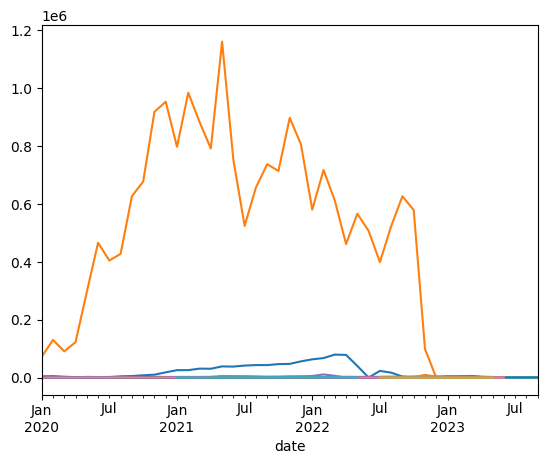

In [19]:
for churned in tqdm(churn_merchants["merchant_id"]):
    train.loc[train["merchant_id"]==churned].groupby("date")["net_payment_count"].sum().plot()

churn merchants incelendiğinde bu işlem sayılarının çoğunun merchant_60635 tarafından yapıldığı ortaya çıkıyor. 

In [13]:
train.loc[train["merchant_id"]=="merchant_60635"].groupby("date")["net_payment_count"].sum().sum()

20555065

<Axes: xlabel='date'>

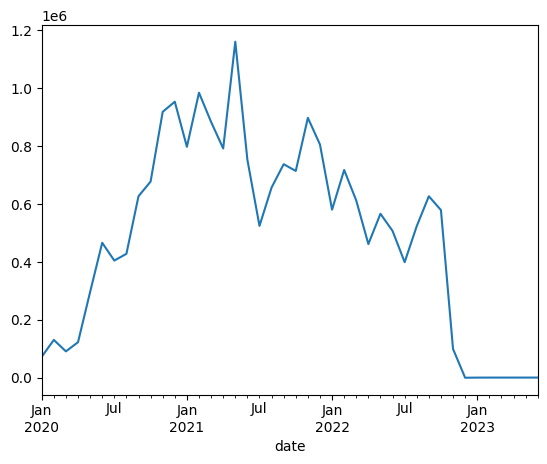

In [20]:
train.loc[train["merchant_id"]=="merchant_60635"].groupby("date")["net_payment_count"].sum().plot()

Veri setindeki toplam işlem sayısınında büyük bir kısmını oluşturuyor.

In [14]:
train["net_payment_count"].sum()

120935787

<Axes: xlabel='date'>

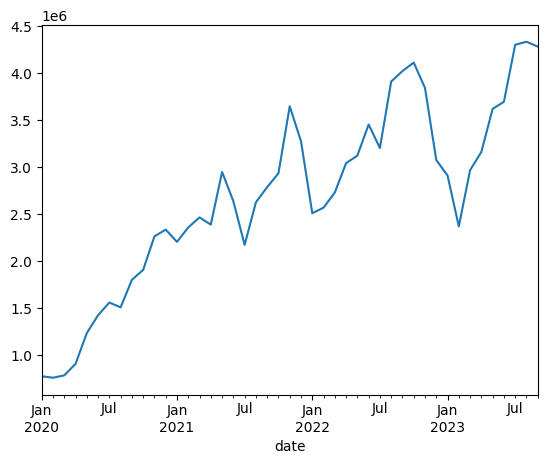

In [15]:
train.groupby("date")["net_payment_count"].sum().plot()

<Axes: ylabel='net_payment_count'>

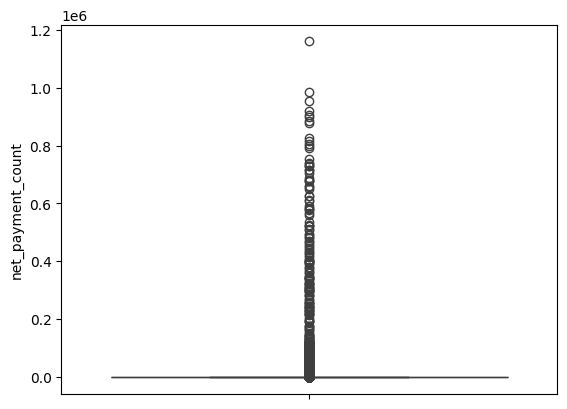

In [16]:
sns.boxplot(train["net_payment_count"])

Target değişkenimiz net payment countun yüksek oranda sağa çarpık olduğunu görüyoruz. merchant_60635 genel dağılımı da etkilemiş.

In [18]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
month_id,291142.0,202159.68086,202001.0,202103.0,202201.0,202211.0,202309.0,104.214948
net_payment_count,291142.0,415.384201,-1433.0,4.0,6.0,14.0,1160429.0,10820.674338
date,291142,2021-12-22 08:43:56.338281728,2020-01-01 00:00:00,2021-03-01 00:00:00,2022-01-01 00:00:00,2022-11-01 00:00:00,2023-09-01 00:00:00,NaN


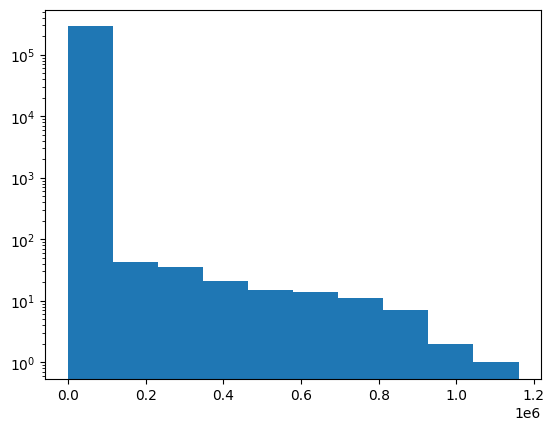

In [24]:
plt.hist(train["net_payment_count"])
plt.yscale('log')

Yüksek sayıda işlem yapan churn olmayan müşterileri incelediğimizde merchant_60635'in etkisi görülüyor.

100%|██████████| 18/18 [00:00<00:00, 34.23it/s]


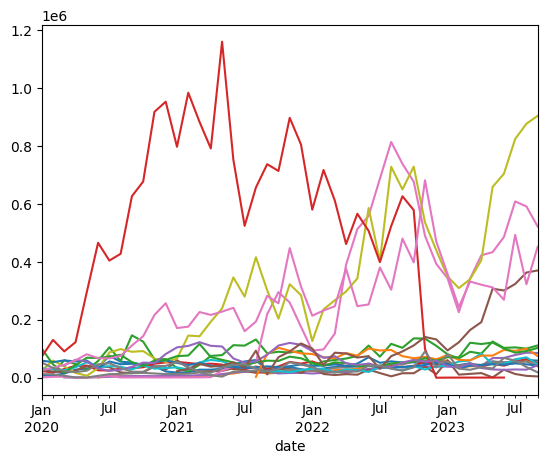

In [21]:
sum_transaction_by_merchant = train.groupby("merchant_id")["net_payment_count"].sum().reset_index()
top_marchants=sum_transaction_by_merchant.loc[sum_transaction_by_merchant["net_payment_count"] > 1000000,["merchant_id","net_payment_count"]]
for top in tqdm(top_marchants["merchant_id"]):
    train.loc[train["merchant_id"]==top].groupby("date")["net_payment_count"].sum().plot()


Train setten churn olan 50 id çıkarılıyor

In [25]:
train=train[~train["merchant_id"].isin(churn_merchants_for_submit["merchant_id"])].reset_index(drop=True)

In [26]:
train["merchant_id"].nunique()

26010

In [27]:
test["merchant_id"].nunique()

26060

Genel ve yüksek oranda işlem yapanların grafikleri incelendiğinde çarpıklık giderilmese bile merhant_60635 in etkisi gideriliyor. Genel yapı korunuyor.

<Axes: xlabel='date'>

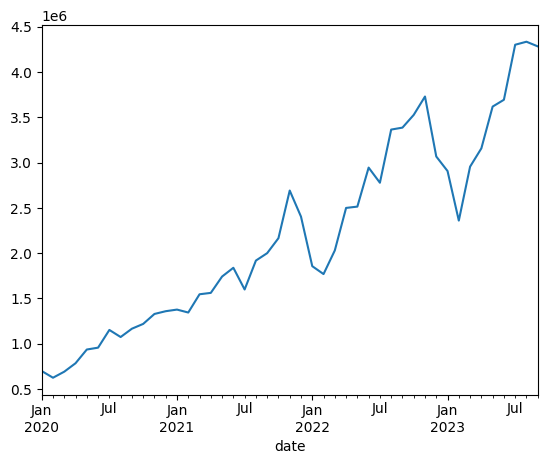

In [28]:
train.groupby("date")["net_payment_count"].sum().plot()

100%|██████████| 17/17 [00:00<00:00, 33.78it/s]


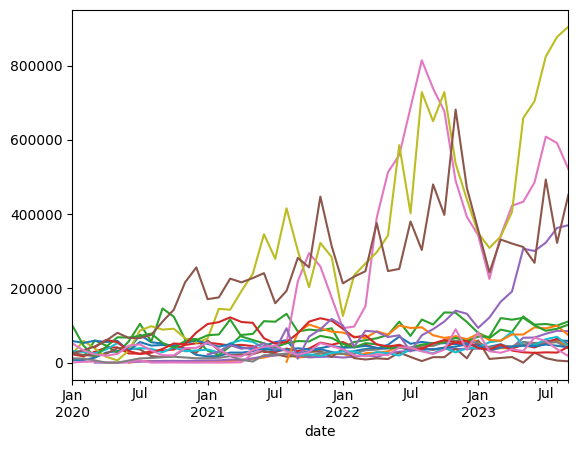

In [30]:
sum_transaction_by_merchant = train.groupby("merchant_id")["net_payment_count"].sum().reset_index()
top_marchants=sum_transaction_by_merchant.loc[sum_transaction_by_merchant["net_payment_count"] > 1000000,["merchant_id","net_payment_count"]]
for top in tqdm(top_marchants["merchant_id"]):
    train.loc[train["merchant_id"]==top].groupby("date")["net_payment_count"].sum().plot()

**NEGATİF VERİLERİN SİLİNMESİ**

Negatif verilerin sayısı çok fazla olmadığından dağılımı düzeltmek adına 0  ile değiştirildi.

In [31]:
train.loc[train["net_payment_count"] < 0,["net_payment_count"]].sum()

net_payment_count   -4386
dtype: int64

In [32]:
train.loc[train["net_payment_count"] < 0,["net_payment_count"]] = 0

In [33]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
month_id,290346.0,202159.702796,202001.0,202103.0,202201.0,202211.0,202309.0,104.223633
net_payment_count,290346.0,341.708617,0.0,4.0,6.0,14.0,904587.0,8182.679806
date,290346,2021-12-22 10:50:05.963919104,2020-01-01 00:00:00,2021-03-01 00:00:00,2022-01-01 00:00:00,2022-11-01 00:00:00,2023-09-01 00:00:00,NaN


**AYKIRI DEĞER ANALİZİ**

In [34]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [35]:
low_limit, up_limit = outlier_thresholds(train,"net_payment_count")

In [36]:
low_limit

-4015.5

In [37]:
up_limit

6700.5

%1 lik dilimdeki müşterilerin işlem sayıları toplam işlem sayısının %82'sini oluşturuyor. Bu nedenle aykırı değerleri çıkarmadım.

In [40]:
total_payment_count=train["net_payment_count"].sum()
percent_1_payment_count = train.loc[train["net_payment_count"]>up_limit,"net_payment_count"].sum()
ratio_of_percent_1 = percent_1_payment_count /total_payment_count
ratio_of_percent_1*100


82.69990151564708

**FEATURE ENGINEERING**

Özelliklerin hem train hem test sete eklenmesi için bu iki dataframe birleştirip eklemeler yapılacak

In [41]:
train_test_concat = pd.concat([train,test],axis=0)

1. MÜŞTERİLERE YAPTIKLARI İŞLEM SAYISINA GÖRE AĞIRLIK VERİLMESİ

Bu işlem için şirketler, yaptıkları işlem sayılarına göre gruplara ayrılacak.

10 milyondan fazla işlemi olan 3 şirket var

In [42]:
sum_transactions = train.groupby("merchant_id")["net_payment_count"].sum().reset_index()
top_marchants=sum_transactions.loc[sum_transactions["net_payment_count"] > 10000000,["merchant_id","net_payment_count"]]
top_marchants

,merchant_id,net_payment_count
9911,merchant_33179,10707197
13419,merchant_41628,14314313
25278,merchant_8318,11472949


In [49]:
def plot_merchants_npc_by_date(filtered_df,search_df=train,id_col="merchant_id"):
    df = filtered_df[id_col]
    for top in tqdm(df):
        search_df.loc[search_df[id_col]==top].groupby("date")["net_payment_count"].sum().plot()
    

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.07it/s]


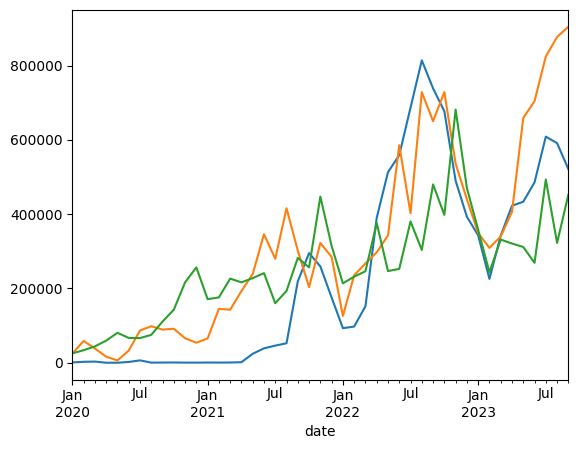

In [50]:
plot_merchants_npc_by_date(top_marchants)

merchant_67459  2023 ocakta büyük yükselişe geçmiş

In [51]:
top_marchants_2=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 3900000)&(sum_transaction_by_merchant["net_payment_count"] < 10000000),["merchant_id","net_payment_count"]]
top_marchants_2

,merchant_id,net_payment_count
24455,merchant_67459,3916500


100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


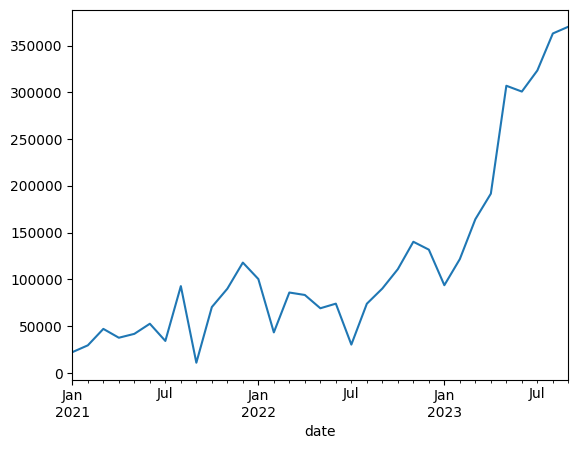

In [52]:
plot_merchants_npc_by_date(top_marchants_2)

3900000 ve 1000000 arası işlem yapan merchantlar

In [53]:
top_marchants_3=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 1000000)&(sum_transaction_by_merchant["net_payment_count"] < 3900000),["merchant_id","net_payment_count"]]
top_marchants_3

,merchant_id,net_payment_count
472,merchant_11040,1825473
1416,merchant_1328,1086169
2606,merchant_16119,3687989
4259,merchant_19986,1859351
8215,merchant_29343,1076809
9600,merchant_32462,1000729
10684,merchant_35133,1276088
16037,merchant_47726,1716485
16260,merchant_48230,1988510
17864,merchant_51990,2016696


100%|██████████| 13/13 [00:00<00:00, 27.62it/s]


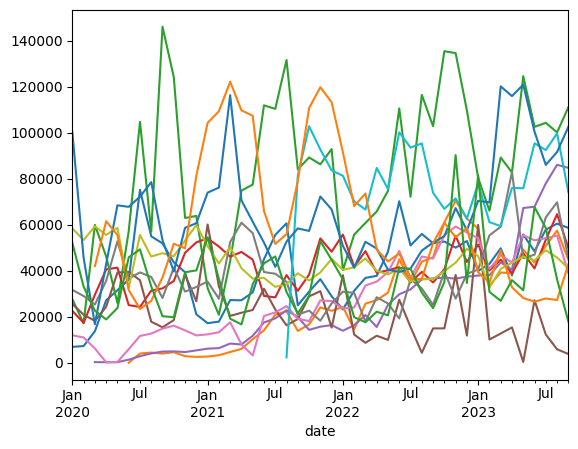

In [54]:
plot_merchants_npc_by_date(top_marchants_3)

100%|██████████| 13/13 [00:00<00:00, 32.58it/s]


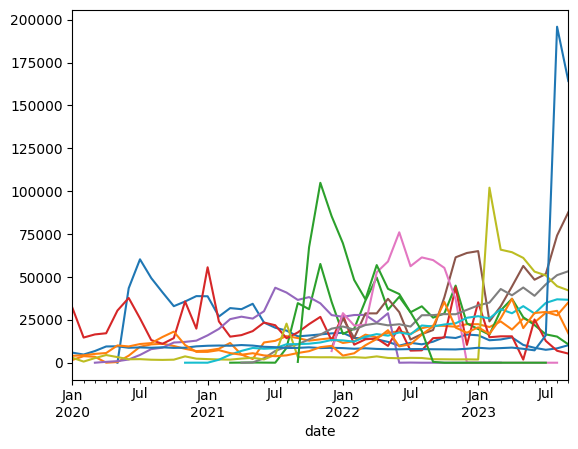

In [55]:
top_marchants_4=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 500000)&(sum_transaction_by_merchant["net_payment_count"] < 1000000),["merchant_id","net_payment_count"]]
plot_merchants_npc_by_date(top_marchants_4)

Haziran 2023 de büyük yükseliş yapan merchant

<Axes: xlabel='date'>

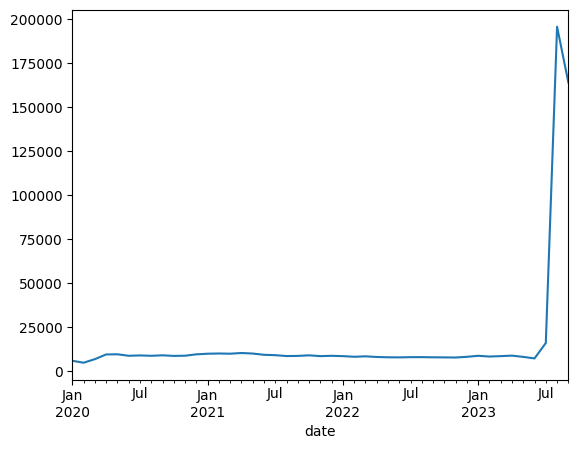

In [56]:
train.loc[train["merchant_id"]=="merchant_56211"].groupby("date")["net_payment_count"].sum().plot()

100%|██████████| 13/13 [00:00<00:00, 32.80it/s]


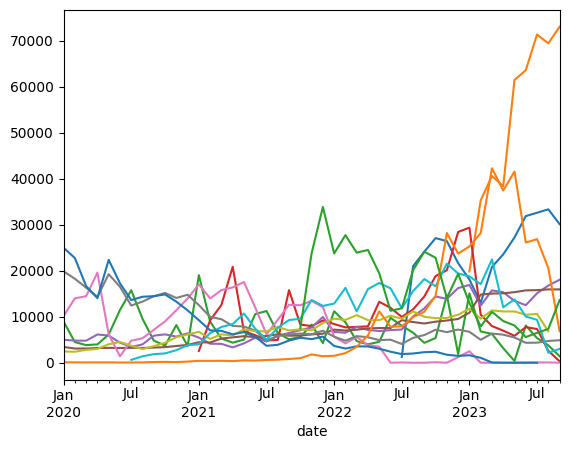

In [57]:
top_marchants_5=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 300000)&(sum_transaction_by_merchant["net_payment_count"] < 500000),["merchant_id","net_payment_count"]]
plot_merchants_npc_by_date(top_marchants_5)

100%|██████████| 12/12 [00:00<00:00, 28.45it/s]


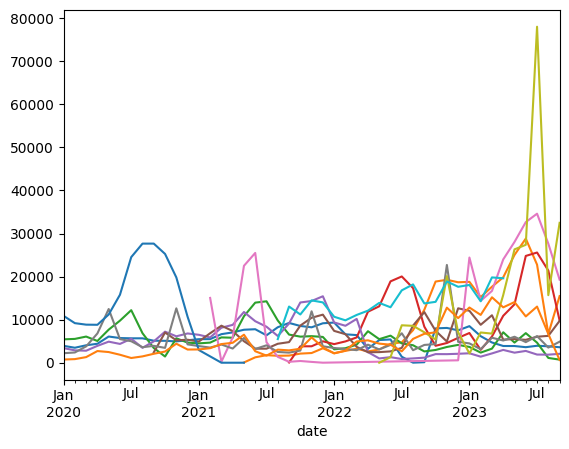

In [58]:
top_marchants_6=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 200000)&(sum_transaction_by_merchant["net_payment_count"] < 300000),["merchant_id","net_payment_count"]]
plot_merchants_npc_by_date(top_marchants_6)

100%|██████████| 30/30 [00:00<00:00, 34.50it/s]


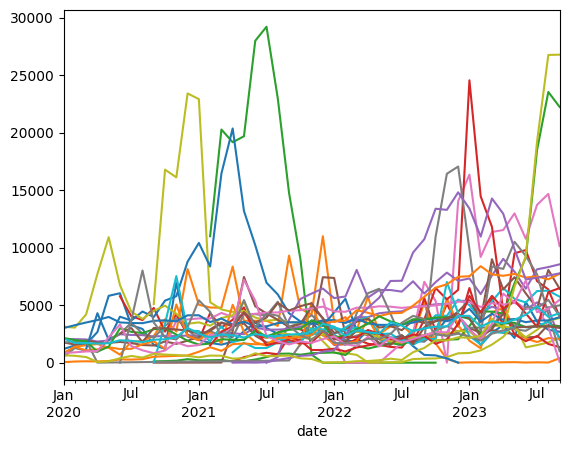

In [59]:
top_marchants_7=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 100000)&(sum_transaction_by_merchant["net_payment_count"] < 200000),["merchant_id","net_payment_count"]]
plot_merchants_npc_by_date(top_marchants_7)

100%|██████████| 46/46 [00:01<00:00, 36.14it/s]


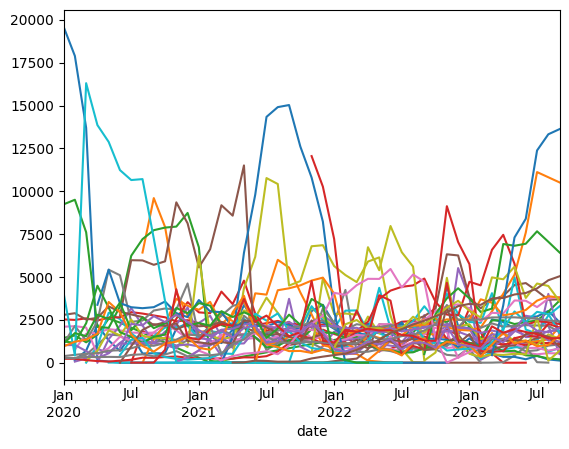

In [60]:
top_marchants_8=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 50000)&(sum_transaction_by_merchant["net_payment_count"] < 100000),["merchant_id","net_payment_count"]]
plot_merchants_npc_by_date(top_marchants_8)

100%|██████████| 203/203 [00:05<00:00, 36.08it/s]


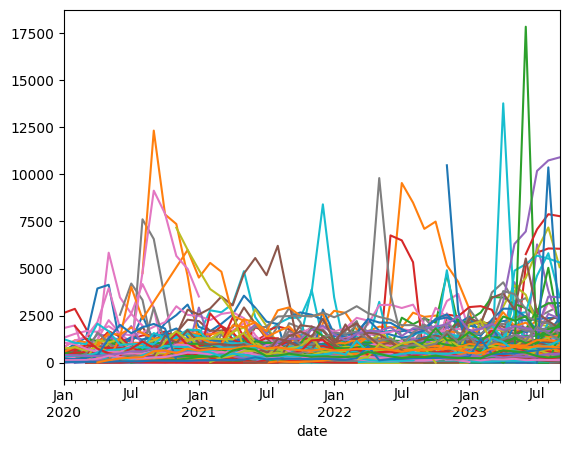

In [61]:
top_marchants_9=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 10000)&(sum_transaction_by_merchant["net_payment_count"] < 50000),["merchant_id","net_payment_count"]]
plot_merchants_npc_by_date(top_marchants_9)

In [62]:
top_marchants_10=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 5000)&(sum_transaction_by_merchant["net_payment_count"] < 10000),["merchant_id","net_payment_count"]]
top_marchants_10.shape

(194, 2)

In [63]:
top_marchants_11=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 1000)&(sum_transaction_by_merchant["net_payment_count"] < 5000),["merchant_id","net_payment_count"]]
top_marchants_12=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 500)&(sum_transaction_by_merchant["net_payment_count"] < 1000),["merchant_id","net_payment_count"]]
top_marchants_13=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 300)&(sum_transaction_by_merchant["net_payment_count"] < 500),["merchant_id","net_payment_count"]]
top_marchants_14=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 200)&(sum_transaction_by_merchant["net_payment_count"] < 300),["merchant_id","net_payment_count"]]
top_marchants_15=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 100)&(sum_transaction_by_merchant["net_payment_count"] < 200),["merchant_id","net_payment_count"]]
top_marchants_16=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 50)&(sum_transaction_by_merchant["net_payment_count"] < 100),["merchant_id","net_payment_count"]]
top_marchants_17=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 30)&(sum_transaction_by_merchant["net_payment_count"] < 50),["merchant_id","net_payment_count"]]
top_marchants_18=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 20)&(sum_transaction_by_merchant["net_payment_count"] < 30),["merchant_id","net_payment_count"]]
top_marchants_19=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 10)&(sum_transaction_by_merchant["net_payment_count"] < 20),["merchant_id","net_payment_count"]]
top_marchants_20=sum_transactions.loc[(sum_transaction_by_merchant["net_payment_count"] > 0)&(sum_transaction_by_merchant["net_payment_count"] < 10),["merchant_id","net_payment_count"]]


Bu kısımda daha fazla inceleme yapılabilir.

AĞIRLIKLARIN BELİRLENMESİ

Şirket işlem sayılarında yüksek oranda farklılıklar olduğu için ağırlıkları şirket gruplarını yansıtması adına aralıkların karekökünü alındı. 

In [64]:
max_value = train.groupby("merchant_id")["net_payment_count"].sum().max()
max_value

14314313

In [65]:
bins = [0, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 5000, 10000, 50000, 100000, 200000, 300000, 500000, 1000000, 3900000,10000000,np.inf] 

[   0    3    4    5    7   10   14   17   22   32   71  100  224  316
  447  548  707 1000 1975 3162]


<Axes: >

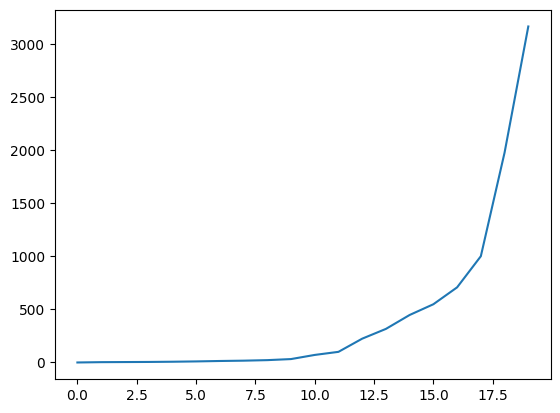

In [66]:
ranges=[0, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 5000, 10000, 50000, 100000, 200000, 300000, 500000, 1000000, 3900000,10000000] 
labels = np.sqrt(ranges)
labels = np.round(labels).astype(int)
labels_seri = pd.Series(labels)
print(labels)
labels_seri.plot()

In [67]:
counts_for_cut = train_test_concat.groupby("merchant_id")["net_payment_count"].sum().reset_index().sort_values("net_payment_count",ascending=False)
counts_for_cut["merchant_sqrt_weights"] = pd.cut(counts_for_cut["net_payment_count"], bins=bins, labels=labels,right=False)
counts_for_cut["merchant_sqrt_weights"] = counts_for_cut["merchant_sqrt_weights"].astype(int)
counts_for_cut.drop("net_payment_count",axis=1,inplace=True)
train_test_concat = pd.merge(train_test_concat, counts_for_cut, on='merchant_id', how='left')
train_test_concat.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,merchant_sqrt_weights
0,202001merchant_66740,merchant_66740,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_130,Segment - 4,6,2020-01-01,10
1,202001merchant_12444,merchant_12444,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 2,mcc_153,Segment - 4,3,2020-01-01,0
2,202001merchant_40154,merchant_40154,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_168,Segment - 4,3,2020-01-01,0
3,202001merchant_33179,merchant_33179,202001,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,787,2020-01-01,3162
4,202001merchant_16977,merchant_16977,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_31,Segment - 4,5,2020-01-01,5


In [68]:
train_test_concat.groupby(["merchant_id","merchant_sqrt_weights"])["net_payment_count"].sum().reset_index().sort_values(["net_payment_count","merchant_sqrt_weights"],ascending=[False,False]).head()

,merchant_id,merchant_sqrt_weights,net_payment_count
13444,merchant_41628,3162,14314313
25328,merchant_8318,3162,11472949
9931,merchant_33179,3162,10707197
24503,merchant_67459,1975,3916500
2609,merchant_16119,1000,3687989


<Axes: xlabel='merchant_id'>

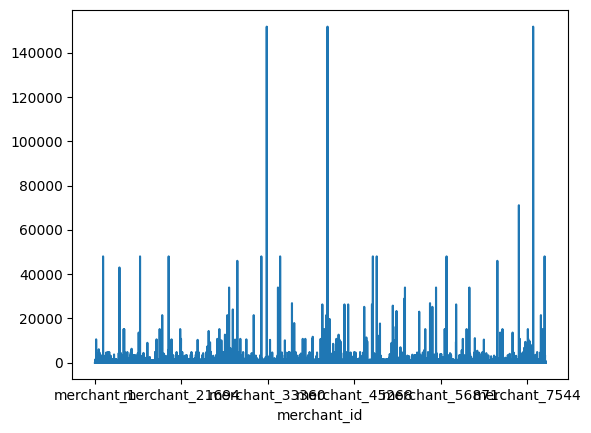

In [69]:
train_test_concat.groupby("merchant_id")["merchant_sqrt_weights"].sum().plot()

2. LABEL ENCODING 

Kategorik değişkenler arasındaki ilişki ordinal olduğundan label encoding tercih edildi.

In [70]:
le = LabelEncoder()
train_test_concat['merchant_source_name'] = le.fit_transform(train_test_concat['merchant_source_name']) + 1 
train_test_concat['settlement_period'] = le.fit_transform(train_test_concat['settlement_period']) + 1
train_test_concat['working_type'] = le.fit_transform(train_test_concat['working_type']) + 1
train_test_concat['mcc_id'] = le.fit_transform(train_test_concat['mcc_id']) + 1
train_test_concat['merchant_segment'] = le.fit_transform(train_test_concat['merchant_segment']) + 1
train_test_concat.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,merchant_sqrt_weights
0,202001merchant_66740,merchant_66740,202001,1,1,6,30,4,6,2020-01-01,10
1,202001merchant_12444,merchant_12444,202001,1,1,2,50,4,3,2020-01-01,0
2,202001merchant_40154,merchant_40154,202001,2,1,5,64,4,3,2020-01-01,0
3,202001merchant_33179,merchant_33179,202001,3,3,2,99,2,787,2020-01-01,3162
4,202001merchant_16977,merchant_16977,202001,2,1,6,106,4,5,2020-01-01,5


3. KATEGORİK DEĞİŞKENLERE AĞIRLIK VERİLMESİ

Yine burda da kategorik değişkenler arasında büyük farklılıklar göze çarpıyor. Her bir kategoriye kök alarak ağırlık verilecek.

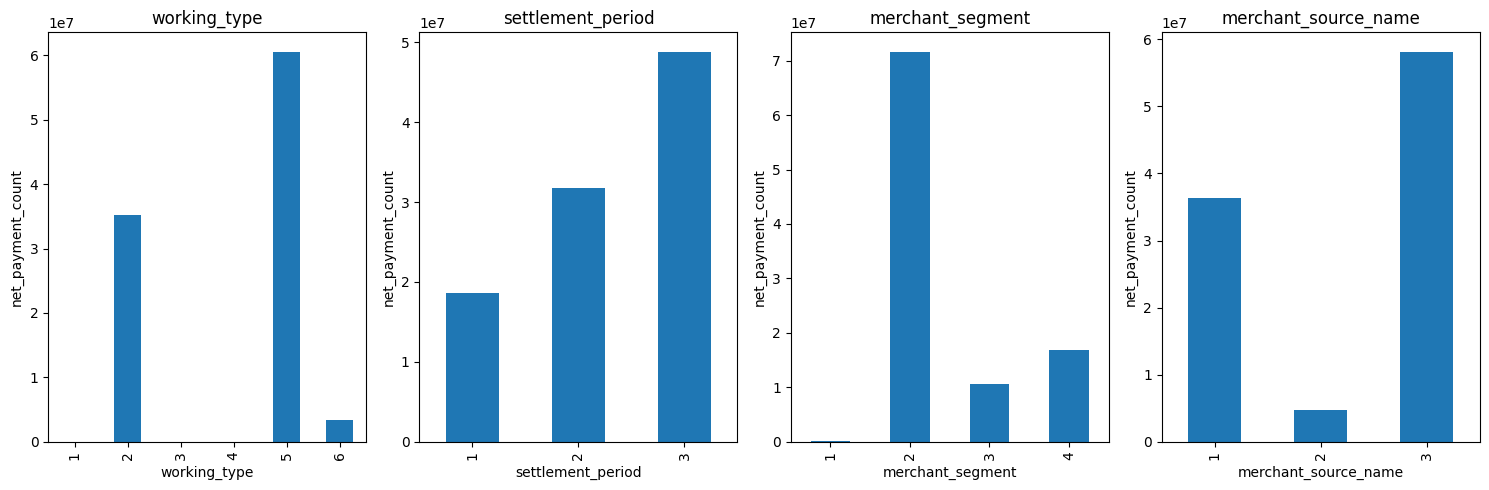

In [133]:
categories = ["working_type", "settlement_period", "merchant_segment", "merchant_source_name"]
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))

for i, category in enumerate(categories):
    train_test_concat.groupby(category)["net_payment_count"].sum().plot(kind="bar", ax=axes[i])
    axes[i].set_title(category)
    axes[i].set_ylabel("net_payment_count")

plt.tight_layout()
plt.show()

In [104]:
def get_squared_total_npc_list_by_category(dataframe,category_name):
    """returns squared total net payment counts by category as a numpy list"""
    values=dataframe.groupby(category_name)["net_payment_count"].sum().values
    labels_npc = np.sqrt(values)
    labels_npc = np.round(labels_npc).astype(int)
    npc_series = pd.Series(labels_npc,index=range(1, len(labels_npc) + 1))
    print(values)
    print(npc_series)
    return npc_series

[     791 35197320    30971     4097 60540122  3440429]
1      28
2    5933
3     176
4      64
5    7781
6    1855
dtype: int32


<Axes: >

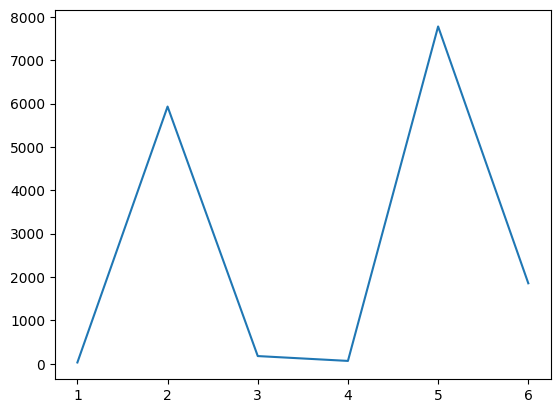

In [106]:
working_type = get_squared_total_npc_list_by_category(train_test_concat,"working_type")
working_type.plot()


[18587743 31814087 48811900]
1    4311
2    5640
3    6987
dtype: int32


<Axes: >

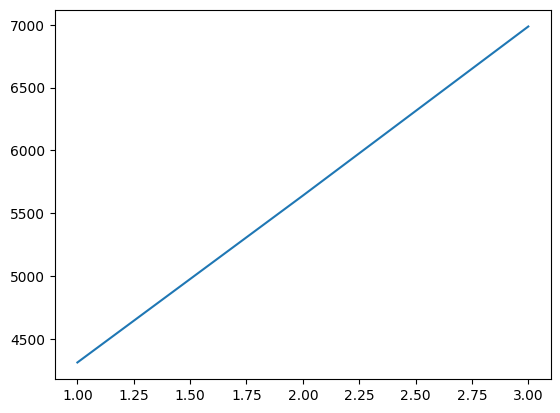

In [107]:
settlement_period = get_squared_total_npc_list_by_category(train_test_concat,"settlement_period")
settlement_period.plot()

[  169588 71625805 10599562 16818775]
1     412
2    8463
3    3256
4    4101
dtype: int32


<Axes: >

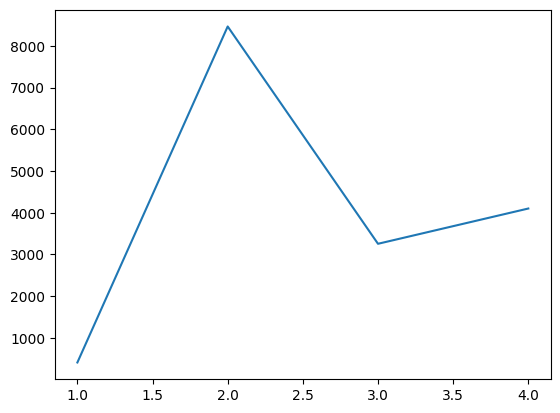

In [108]:
merchant_segment = get_squared_total_npc_list_by_category(train_test_concat,"merchant_segment")
merchant_segment.plot()

[36317615  4750625 58145490]
1    6026
2    2180
3    7625
dtype: int32


<Axes: >

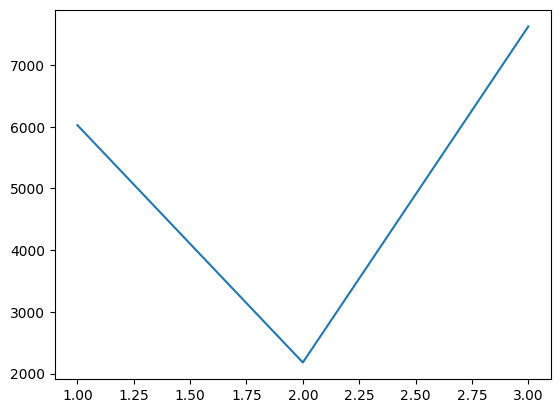

In [132]:
merchant_source_name = get_squared_total_npc_list_by_category(train_test_concat,"merchant_source_name")
merchant_source_name.plot()

In [128]:
train_test_concat.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,merchant_sqrt_weights
0,202001merchant_66740,merchant_66740,202001,1,1,6,30,4,6,2020-01-01,10
1,202001merchant_12444,merchant_12444,202001,1,1,2,50,4,3,2020-01-01,0
2,202001merchant_40154,merchant_40154,202001,2,1,5,64,4,3,2020-01-01,0
3,202001merchant_33179,merchant_33179,202001,3,3,2,99,2,787,2020-01-01,3162
4,202001merchant_16977,merchant_16977,202001,2,1,6,106,4,5,2020-01-01,5


In [129]:
train_test_concat["weighted_factor_for_working_type"] = train_test_concat["working_type"].map(working_type)
train_test_concat["weighted_factor_for_settlement_period"] = train_test_concat["settlement_period"].map(settlement_period)
train_test_concat["weighted_factor_for_merchant_segment"] = train_test_concat["merchant_segment"].map(merchant_segment)
train_test_concat["weighted_factor_for_merchant_source_name"] = train_test_concat["merchant_source_name"].map(merchant_source_name)
train_test_concat.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,merchant_sqrt_weights,weighted_factor_for_working_type,weighted_factor_for_settlement_period,weighted_factor_for_merchant_segment,weighted_factor_for_merchant_source_name
0,202001merchant_66740,merchant_66740,202001,1,1,6,30,4,6,2020-01-01,10,1855,4311,4101,6026
1,202001merchant_12444,merchant_12444,202001,1,1,2,50,4,3,2020-01-01,0,5933,4311,4101,6026
2,202001merchant_40154,merchant_40154,202001,2,1,5,64,4,3,2020-01-01,0,7781,4311,4101,2180
3,202001merchant_33179,merchant_33179,202001,3,3,2,99,2,787,2020-01-01,3162,5933,6987,8463,7625
4,202001merchant_16977,merchant_16977,202001,2,1,6,106,4,5,2020-01-01,5,1855,4311,4101,2180


4. MERCHANT  BAŞI KATEGORİ SAYISI EKLENDİ

In [134]:
train_test_concat['category_count']= train_test_concat.groupby('merchant_id')['mcc_id'].transform("count")

5. YIL VE AY DEĞİŞKENLERİ EKLENDİ

In [136]:
train_test_concat['year'] = train_test_concat['date'].dt.year
train_test_concat['month'] = train_test_concat['date'].dt.month

6. KATEGORİ KIRILIMLARINA GÖRE ORTALAMA NET PAYMENT COUNT ORANI EKLENDİ

In [140]:
train_test_concat["combined_category"] = train_test_concat[["merchant_source_name","settlement_period","working_type", "merchant_segment"]].apply(lambda row: ''.join(map(str, row)), axis=1)
train_test_concat["combined_category"].nunique()

76

In [291]:
def add_feature_avg_payment_count_by_category(dataframe,category_name,target_name,plot=True):
    avg_transactions_per_category_name  = dataframe.groupby(category_name)[target_name].mean()
    avg_transactions = dataframe[target_name].mean()
    ratio = avg_transactions_per_category_name / avg_transactions
    dataframe[f"{category_name}_transaction_ratio"] = dataframe[category_name].map(ratio)
    print(f"{category_name}_transaction_ratio feature has been added to dataframe!")

    if plot:
        monthly_avg_payment_count=dataframe.groupby("date")[target_name].mean().reset_index()
        category_type= dataframe.groupby("date")[f"{category_name}_transaction_ratio"].mean().reset_index()
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('date')
        ax1.set_ylabel(target_name, color=color)
        ax1.plot(monthly_avg_payment_count["date"], monthly_avg_payment_count[target_name], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel(category_name, color=color)
        ax2.plot(category_type["date"], category_type[f"{category_name}_transaction_ratio"], color=color)
        ax2.tick_params(axis='y', labelcolor=color)

 38%|███▊      | 3/8 [00:00<00:00, 11.60it/s]

merchant_id_transaction_ratio feature has been added to dataframe!
merchant_source_name_transaction_ratio feature has been added to dataframe!
settlement_period_transaction_ratio feature has been added to dataframe!
working_type_transaction_ratio feature has been added to dataframe!


 88%|████████▊ | 7/8 [00:00<00:00, 15.69it/s]

mcc_id_transaction_ratio feature has been added to dataframe!
merchant_segment_transaction_ratio feature has been added to dataframe!
category_count_transaction_ratio feature has been added to dataframe!
combined_category_transaction_ratio feature has been added to dataframe!


100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


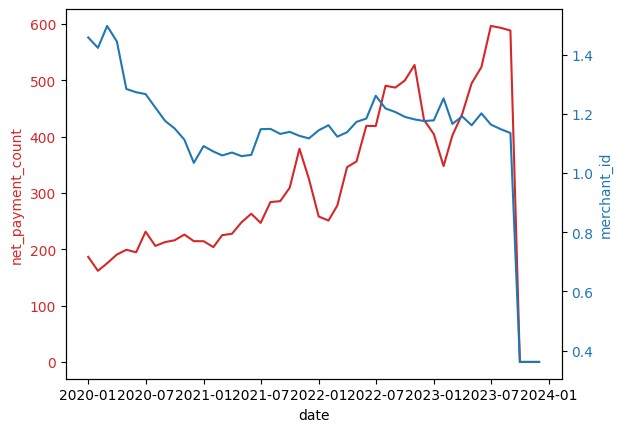

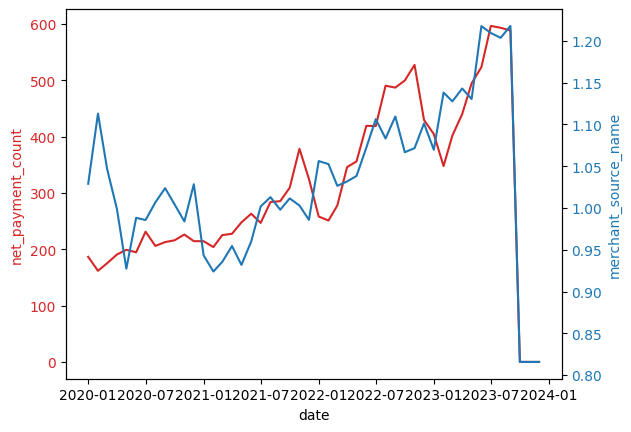

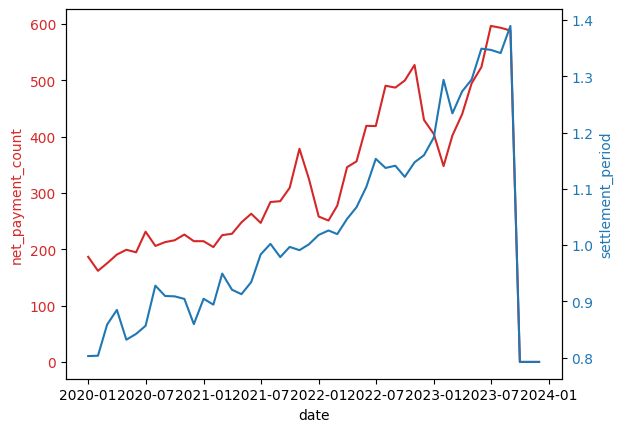

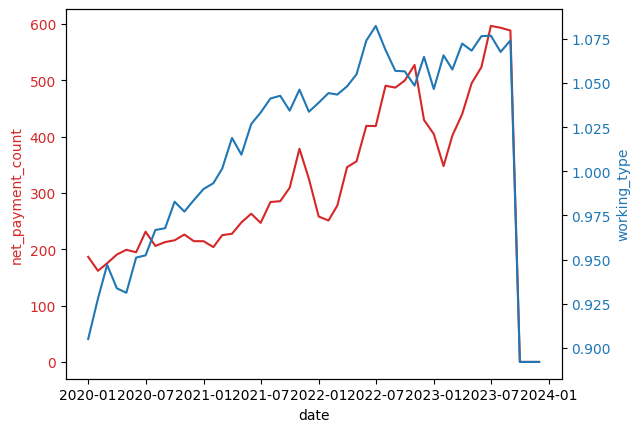

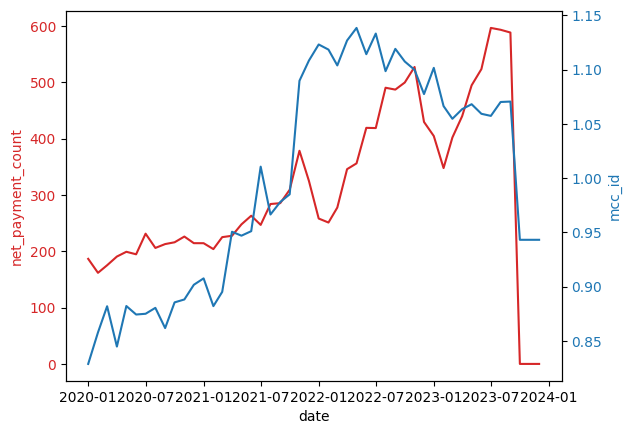

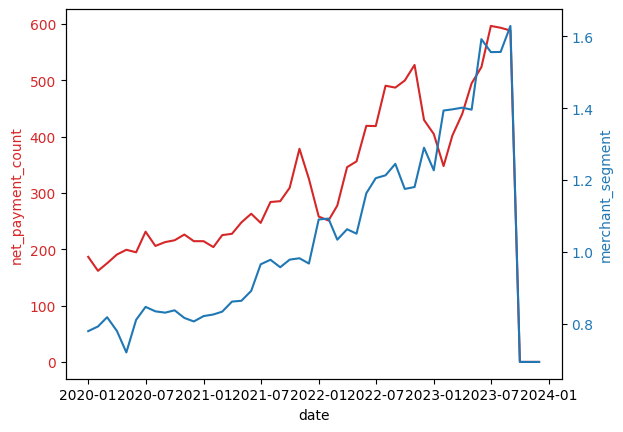

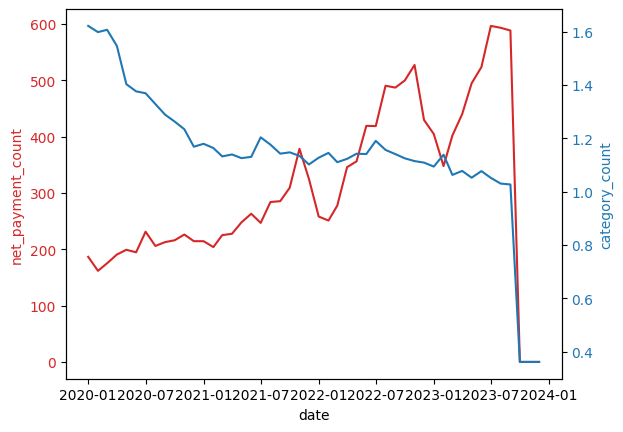

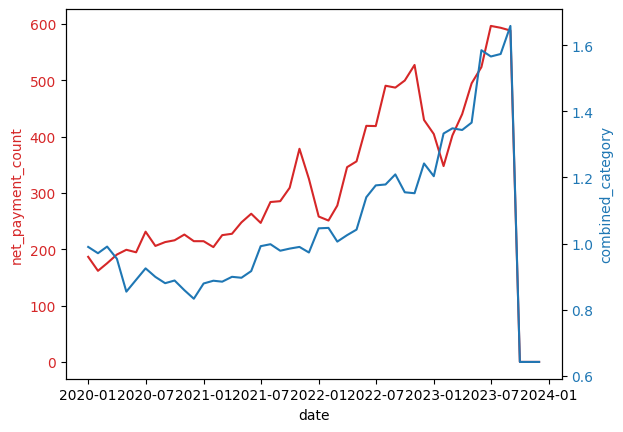

In [292]:
category_list_for_ratio_calculation = ["merchant_id","merchant_source_name","settlement_period","working_type","mcc_id","merchant_segment","category_count","combined_category"]
target_name = "net_payment_count"
for category in tqdm(category_list_for_ratio_calculation):
    add_feature_avg_payment_count_by_category(train_test_concat,category,target_name)


In [294]:
train_test_concat.drop(["combined_category"], axis=1, inplace=True)
train_test_concat.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,...,year,month,merchant_id_transaction_ratio,merchant_source_name_transaction_ratio,settlement_period_transaction_ratio,working_type_transaction_ratio,mcc_id_transaction_ratio,merchant_segment_transaction_ratio,category_count_transaction_ratio,combined_category_transaction_ratio
0,202001merchant_66740,merchant_66740,202001,1,1,6,30,4,6,2020-01-01,...,2020,1,0.016261,0.639351,0.201741,0.076792,0.619995,0.175360,0.249636,0.049677
1,202001merchant_12444,merchant_12444,202001,1,1,2,50,4,3,2020-01-01,...,2020,1,0.005572,0.639351,0.201741,2.707770,0.074885,0.175360,0.019364,0.231737
2,202001merchant_40154,merchant_40154,202001,2,1,5,64,4,3,2020-01-01,...,2020,1,0.005572,0.124226,0.201741,1.556029,0.420962,0.175360,0.019364,0.068040
3,202001merchant_33179,merchant_33179,202001,3,3,2,99,2,787,2020-01-01,...,2020,1,828.573257,13.950357,7.433485,2.707770,56.111969,33.857419,8.210622,22.616462
4,202001merchant_16977,merchant_16977,202001,2,1,6,106,4,5,2020-01-01,...,2020,1,0.009286,0.124226,0.201741,0.076792,0.012415,0.175360,0.270883,0.054260


7. DIŞ VERİ EKLEME İŞLEMLERİ

Enflasyon oranı eklenmesi (üfe + tüfe / 2). Veriler Tuikten alınmıştır.

In [295]:
ufe = pd.read_csv("data/ufe.csv",sep=";")
ufe['yi_ufe'] = ufe["yi_ufe"].str.replace(",",".").astype("float64")
ufe["date"] = pd.to_datetime(ufe["month_id"], format="%Y%m")
ufe.sort_values("date",inplace=True)
ufe.drop(["id","month_id"],axis=1,inplace=True)

tufe = pd.read_csv("data/tufe.csv",sep=";")
tufe['tufe'] = tufe["tufe"].str.replace(",",".").astype("float64")
tufe["date"] = pd.to_datetime(tufe["month_id"], format="%Y%m")
tufe.sort_values("date",inplace=True)
tufe.drop(["id","month_id"],axis=1,inplace=True)

ufe_tufe = tufe.merge(ufe, on="date",how="left")
train_test_concat=train_test_concat.merge(ufe_tufe,on="date",how="left")
train_test_concat["enf_rate"] = (train_test_concat["tufe"] + train_test_concat["yi_ufe"]) / 2

train_test_concat.drop(["tufe","yi_ufe"],axis=1,inplace=True)
train_test_concat.head()


,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,...,month,merchant_id_transaction_ratio,merchant_source_name_transaction_ratio,settlement_period_transaction_ratio,working_type_transaction_ratio,mcc_id_transaction_ratio,merchant_segment_transaction_ratio,category_count_transaction_ratio,combined_category_transaction_ratio,enf_rate
0,202001merchant_66740,merchant_66740,202001,1,1,6,30,4,6,2020-01-01,...,1,0.016261,0.639351,0.201741,0.076792,0.619995,0.175360,0.249636,0.049677,1.595
1,202001merchant_12444,merchant_12444,202001,1,1,2,50,4,3,2020-01-01,...,1,0.005572,0.639351,0.201741,2.707770,0.074885,0.175360,0.019364,0.231737,1.595
2,202001merchant_40154,merchant_40154,202001,2,1,5,64,4,3,2020-01-01,...,1,0.005572,0.124226,0.201741,1.556029,0.420962,0.175360,0.019364,0.068040,1.595
3,202001merchant_33179,merchant_33179,202001,3,3,2,99,2,787,2020-01-01,...,1,828.573257,13.950357,7.433485,2.707770,56.111969,33.857419,8.210622,22.616462,1.595
4,202001merchant_16977,merchant_16977,202001,2,1,6,106,4,5,2020-01-01,...,1,0.009286,0.124226,0.201741,0.076792,0.012415,0.175360,0.270883,0.054260,1.595


<Axes: xlabel='date', ylabel='enf_rate'>

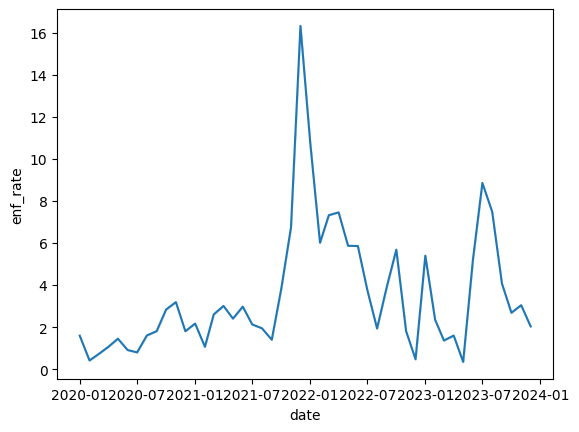

In [297]:
sns.lineplot(x="date",y="enf_rate",data=train_test_concat)

İnternet kredi kartı harcamaları eklendi

Veriler Merkez bankasından alınmıştır. Iyzico üzerinden yapılan işlemler ile internetten kredi kartı ile yapılan işlemlerin oranı elde edilmiştir.

In [300]:
credit_cart_counts = pd.read_csv("data/ev.csv",sep=";")
credit_cart_counts['date'] = credit_cart_counts["date"].str.replace("-","")
credit_cart_counts['KA50'] = credit_cart_counts["KA50"].str.replace(".","").astype("int64")
credit_cart_counts["date"] = pd.to_datetime(credit_cart_counts["date"], format="%Y%m")
credit_cart_counts.sort_values("date",inplace=True)
credit_cart_counts.columns = ["date","credit_card_counts"]
train_test_concat=train_test_concat.merge(credit_cart_counts,on="date",how="left")
train_test_concat["iyzico_ratio_per_total_ccard"] = train_test_concat["net_payment_count"] /  train_test_concat["credit_card_counts"]
train_test_concat.drop("credit_card_counts",axis=1,inplace=True)

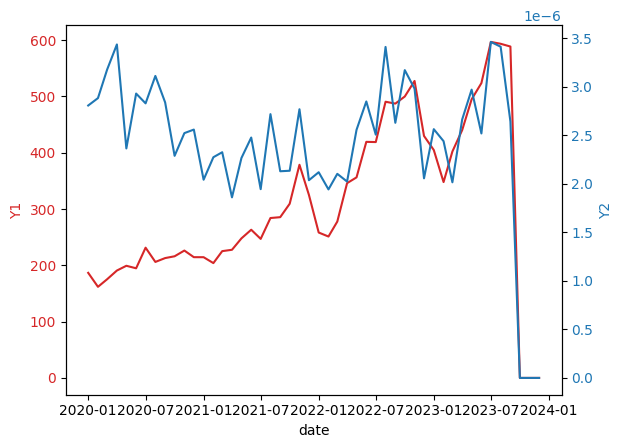

In [302]:
monthly_avg_payment_count=train_test_concat.groupby("date")["net_payment_count"].mean().reset_index()
avg_ccard_group= train_test_concat.groupby("date")["iyzico_ratio_per_total_ccard"].mean().reset_index()
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('Y1', color=color)
ax1.plot(monthly_avg_payment_count["date"], monthly_avg_payment_count["net_payment_count"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Y2', color=color)
ax2.plot(avg_ccard_group["date"], avg_ccard_group["iyzico_ratio_per_total_ccard"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

Sıcaklık verisi (2020 - 2023 aylık ortalama sıcaklıklar)

In [303]:
temp = ufe.copy()
temp_list = [2.9,4.1,7.7,12.3,17.1,21.8,25.0,25.1,20.9,15.6,9.3,4.8,2.9,4.1,7.7,12.3,17.1,21.8,25.0,25.1,20.9,15.6,9.3,4.8,2.2,5.4,4.1,14.3,16.9,22.4,25.0,26.4,21.9,16.3,11.4,8.0,5.3,3.4,9.8,12.3,16.4,21.4,25.7,27.1,22.4,17.1,12.5,8.3]
temp["avg_temp"] = temp_list
avg_temp=temp.reset_index()
new_avg_temp = avg_temp[["date","avg_temp"]]
train_test_concat=train_test_concat.merge(new_avg_temp,on="date",how="left")
train_test_concat["avg_temp_squared"] = train_test_concat["avg_temp"]**2


<Axes: xlabel='date', ylabel='avg_temp_squared'>

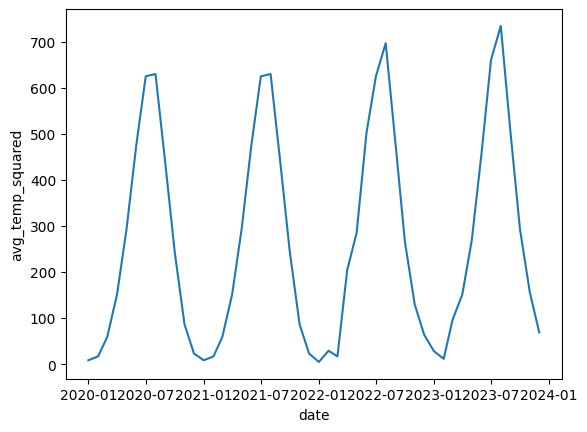

In [304]:
avg_temp_group= train_test_concat.groupby("date")["avg_temp_squared"].mean().reset_index()
sns.lineplot(x="date",y="avg_temp_squared",data=avg_temp_group)

Covid aylık ölüm sayıları eklenmiştir.

In [305]:
covid_deaths = pd.read_csv("data/covid_deaths.csv",sep=";")
covid_deaths["date"] = pd.to_datetime(covid_deaths["date"], format="%Y%m")
covid_deaths.sort_values("date",inplace=True)
train_test_concat=train_test_concat.merge(covid_deaths,on="date",how="left")

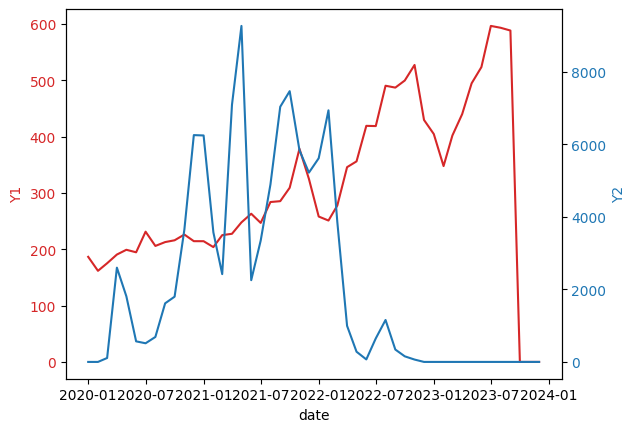

In [306]:
monthly_avg_payment_count=train_test_concat.groupby("date")["net_payment_count"].mean().reset_index()
covid_deaths_group= train_test_concat.groupby("date")["covid_deaths"].mean().reset_index()
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('Y1', color=color)
ax1.plot(monthly_avg_payment_count["date"], monthly_avg_payment_count["net_payment_count"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Y2', color=color)
ax2.plot(covid_deaths_group["date"], covid_deaths_group["covid_deaths"], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

Black friday, yılbaşı, tatil günleri ve bayramlar eklenmiştir.

In [307]:
special_days = pd.read_csv("data/ozel_gunler.csv",sep=";")
special_days["date"] = pd.to_datetime(special_days["date"], format="%Y%m")
special_days.sort_values("date",inplace=True)
train_test_concat=train_test_concat.merge(special_days,on="date",how="left")

Aylık dolar kuru ve % değişim miktarı investingden alınarak eklenmiştir.

In [310]:
usd = pd.read_csv("data/usd.csv",sep="\t")
usd['usd'] = usd["usd"].str.replace(",",".").astype("float64")
usd['usd_perc'] = usd['usd_perc'].str.replace("%", "")
usd['usd_perc'] = usd['usd_perc'].str.replace(",", ".").astype("float64")
usd["date"] = pd.to_datetime(usd["date"], format="%Y%m")
usd.sort_values("date",ascending=True,inplace=True)
train_test_concat=train_test_concat.merge(usd,on="date",how="left")

8. ZAMAN SERİSİ ÖZELLİKLERİ EKLENDİ

Sıralı ay verisi eklendi

In [312]:
month_idxs = {202001: 1, 202002: 2, 202003: 3, 202004: 4, 202005: 5, 202006: 6,
                   202007: 7, 202008: 8, 202009: 9, 202010: 10, 202011: 11, 202012: 12,
                   202101: 13, 202102: 14, 202103: 15, 202104: 16, 202105: 17, 202106: 18,
                   202107: 19, 202108: 20, 202109: 21, 202110: 22, 202111: 23, 202112: 24,
                   202201: 25, 202202: 26, 202203: 27, 202204: 28, 202205: 29, 202206: 30,
                   202207: 31, 202208: 32, 202209: 33, 202210: 34, 202211: 35, 202212: 36,
                   202301: 37, 202302: 38, 202303: 39, 202304: 40, 202305: 41, 202306: 42,
                   202307: 43, 202308: 44, 202309: 45, 202310: 46, 202311: 47, 202312: 48}
train_test_concat["linear_month"] = train_test_concat["month_id"].apply(lambda x : month_idxs[int(x)])


In [314]:
time_series_group = train_test_concat.groupby('date')['net_payment_count'].sum().reset_index()
time_series_group.set_index("date",inplace=True)
time_series_group=time_series_group.resample('MS').asfreq()
time_series_group.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-01-01 to 2023-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   net_payment_count  48 non-null     int64
dtypes: int64(1)
memory usage: 768.0 bytes


<Axes: xlabel='date'>

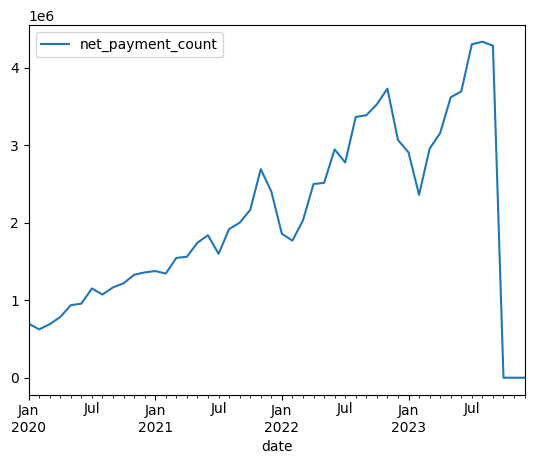

In [315]:
time_series_group.plot()

In [316]:
time_series_group.tail()

,net_payment_count
date,
2023-08-01,4333672
2023-09-01,4282415
2023-10-01,0
2023-11-01,0
2023-12-01,0


Zaman serisi hareketli ortalamalar, sezonsallık, % değişim eklemek için Son 3 ay için arima modeli yapılabilir. Burada geçmiş verilerden yaklaşık bir hesap yapıldı.

In [319]:
last_3_months_according_to_yearly_change = [4367984,3620790,2834553]
time_series_group.loc[time_series_group.index[-3:],"net_payment_count"] = last_3_months_according_to_yearly_change
time_series_group.tail()

,net_payment_count
date,
2023-08-01,4333672
2023-09-01,4282415
2023-10-01,4367984
2023-11-01,3620790
2023-12-01,2834553


İyzico kullanımının yıllar içerisinde yüzde değişimini görmek için verilere normalizasyon yapıldı.
Başlangıçtan itibaren sürekli yükselen bir trend görüyoruz. Yılların son çeyreklerinde periyodik bir düşüş gözlemliyoruz.


<Axes: xlabel='date'>

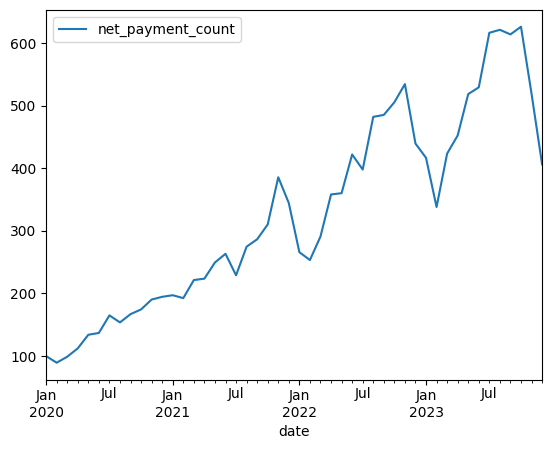

In [320]:
normalized = time_series_group.div(time_series_group.iloc[0]).mul(100)
normalized.plot()

3 aylık % değişim eklenmesi

<Axes: xlabel='date'>

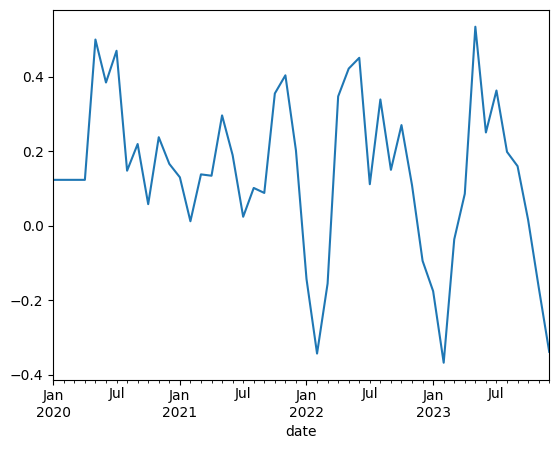

In [324]:
time_series_group["percent_change_3_months"]=time_series_group["net_payment_count"].pct_change(periods=3)
time_series_group["percent_change_3_months"].fillna(method='bfill', inplace=True)
time_series_group["percent_change_3_months"].plot()

3 aylık seasonality eklendi

<Axes: xlabel='date'>

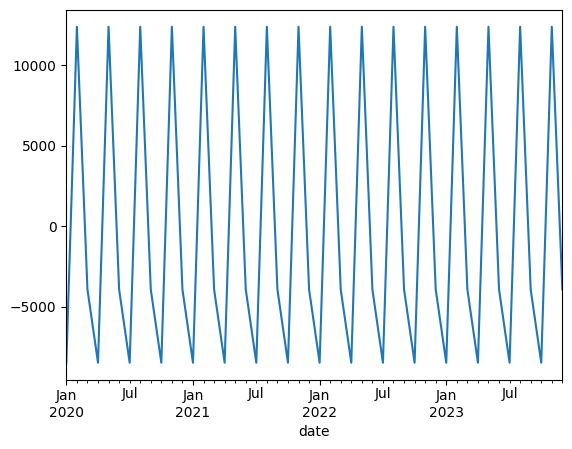

In [325]:
decomposition = seasonal_decompose(time_series_group["net_payment_count"],model="additive",period=3)
time_series_group["seasonal_3_month"] = decomposition.seasonal
time_series_group["seasonal_3_month"].plot()

3, 6 ve 12 aylık hareketli ortalamalar eklendi

<Axes: xlabel='date'>

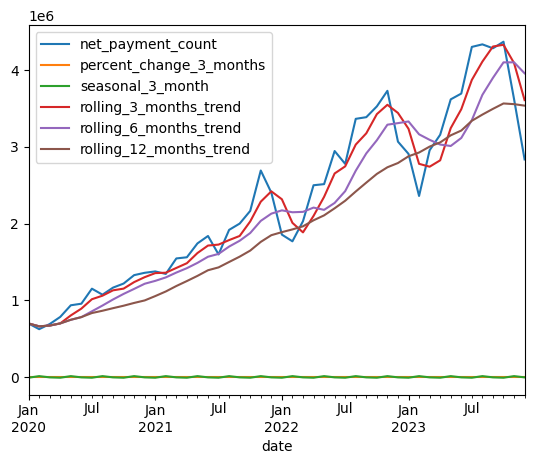

In [326]:
time_series_group["rolling_3_months_trend"] = time_series_group["net_payment_count"].rolling(window=3,min_periods=1).mean()
time_series_group["rolling_6_months_trend"] = time_series_group["net_payment_count"].rolling(window=6,min_periods=1).mean()
time_series_group["rolling_12_months_trend"] = time_series_group["net_payment_count"].rolling(window=12,min_periods=1).mean()
time_series_group.plot()


In [327]:
time_series_group.reset_index(inplace=True)
time_series_group.drop("net_payment_count",inplace=True,axis=1)
train_test_concat= train_test_concat.merge(time_series_group,on="date",how="left")
train_test_concat.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,...,tatil,bayramlar,usd,usd_perc,linear_month,percent_change_3_months,seasonal_3_month,rolling_3_months_trend,rolling_6_months_trend,rolling_12_months_trend
0,202001merchant_66740,merchant_66740,202001,1,1,6,30,4,6,2020-01-01,...,1,0,5.9881,0.56,1,0.122981,-8484.797222,697853.0,697853.0,697853.0
1,202001merchant_12444,merchant_12444,202001,1,1,2,50,4,3,2020-01-01,...,1,0,5.9881,0.56,1,0.122981,-8484.797222,697853.0,697853.0,697853.0
2,202001merchant_40154,merchant_40154,202001,2,1,5,64,4,3,2020-01-01,...,1,0,5.9881,0.56,1,0.122981,-8484.797222,697853.0,697853.0,697853.0
3,202001merchant_33179,merchant_33179,202001,3,3,2,99,2,787,2020-01-01,...,1,0,5.9881,0.56,1,0.122981,-8484.797222,697853.0,697853.0,697853.0
4,202001merchant_16977,merchant_16977,202001,2,1,6,106,4,5,2020-01-01,...,1,0,5.9881,0.56,1,0.122981,-8484.797222,697853.0,697853.0,697853.0
